In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [5]:
sns.set_style("darkgrid")

In [6]:
df = pd.read_csv("carer.csv", index_col=0)
df = df[df["split"] == 1]
df.head()

,text,emotions,split
333346,i dont feel resigned to my fate because i know...,4,1
333347,i am feeling very grouchy since i returned,0,1
333348,i still feel shaken,1,1
333349,i was feeling very lonely and wanting to get a...,4,1
333350,im not as frustrated and crabby like i used to...,0,1


In [7]:
from decks import load_carer

ds, _, _ = load_carer(512)

2022-09-09 20:12:41.000497: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-09 20:12:41.000759: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-09 20:12:41.000813: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-09 20:12:41.000886: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-09-09 20:12:41.000934: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [8]:
from decks.nets import metrics
from decks.nets.utils import text_encoder

# def build_net(ds):
#     outputs = 6
#     h1, h2 = 45, 27

#     enc = text_encoder(ds, None)
#     model = tf.keras.Sequential(
#         [
#             enc,
#             tf.keras.layers.Embedding(
#                 input_dim=len(enc.get_vocabulary()),
#                 output_dim=h1,
#                 mask_zero=True,
#             ),
#             tf.keras.layers.Bidirectional(tf.keras.layers.GRU(h1)),
#             tf.keras.layers.Dense(h2, activation="relu"),
#             tf.keras.layers.Dense(outputs, activation="softmax"),
#         ]
#     )
#     model.compile(
#         loss="sparse_categorical_crossentropy",
#         optimizer="adam",
#         metrics=[
#             "accuracy",
#             *[metrics.PrecisionForClass(x) for x in range(outputs)],
#             *[metrics.RecallForClass(x) for x in range(outputs)],
#             *[metrics.MccForClass(x) for x in range(outputs)],
#         ],
#     )
#     return model

def build_net(ds):
    outputs = 6
    h1, h2 = 67, 40

    enc = text_encoder(ds, None)
    model = tf.keras.Sequential(
        [
            enc,
            tf.keras.layers.Embedding(
                input_dim=len(enc.get_vocabulary()),
                output_dim=h1,
                mask_zero=True,
            ),
            tf.keras.layers.Bidirectional(tf.keras.layers.GRU(h1, dropout=0.5)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(h2, activation="relu"),
            tf.keras.layers.Dense(outputs, activation="softmax"),
        ]
    )
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy",
            *[metrics.PrecisionForClass(x) for x in range(outputs)],
            *[metrics.RecallForClass(x) for x in range(outputs)],
            *[metrics.MccForClass(x) for x in range(outputs)],
            *[metrics.F1ForClass(x) for x in range(outputs)],
        ],
    )
    return model


In [26]:
GEN = 4
EPOCHS = 100

In [36]:
from decks import DATA_DIR

net = build_net(ds)
# weights = tf.train.latest_checkpoint(DATA_DIR / "checkpoints/2001-0100-0512")
weights = DATA_DIR / f"checkpoints/200{GEN}-0100-0512/cp-{EPOCHS:>04}.ckpt"
net.load_weights(weights)
weights

PosixPath('/home/parafoxia/Programs/Projects/decks/data/checkpoints/2004-0100-0512/cp-0100.ckpt')

In [37]:
y_true = df["emotions"].values
y_score = net.predict(df["text"])
y_pred = np.argmax(y_score, axis=1)

1283/1283 [==============================] - 9s 5ms/step


In [38]:
acc = (np.count_nonzero(y_true == y_pred) / len(y_true)) * 100

tp, tn, fp, fn = 0, 0, 0, 0
pre, rec, mcc = [], [], []

for i in range(6):
    tp += np.count_nonzero((y_pred == i) & (y_true == i))
    tn += np.count_nonzero((y_pred != i) & (y_true != i))
    fp += np.count_nonzero((y_pred == i) & (y_true != i))
    fn += np.count_nonzero((y_pred != i) & (y_true == i))

    pre.append(tp / (tp + fp))
    rec.append(tp / (tp + fn))
    mcc.append((tp*tn - fp*fn) / (((tp+fn) * (tp+fp) * (tn+fp) * (tn+fn)) ** 0.5))

print(f"  ACC: {acc / 100:.3f}")
print(f"maPRE: {sum(pre) / len(pre):.3f}")
print(f"maREC: {sum(rec) / len(rec):.3f}")
print(f"maMCC: {sum(mcc) / len(mcc):.3f}")

  ACC: 0.902
maPRE: 0.902
maREC: 0.913
maMCC: 0.889


In [39]:
np.round(y_score[np.where(np.max(y_score, axis=1) == np.min(np.max(y_score, axis=1)))[0][0]], 3)

array([0.   , 0.039, 0.342, 0.274, 0.345, 0.   ], dtype=float32)

In [40]:
from sklearn import metrics as skmetrics
from sklearn.preprocessing import normalize

data = skmetrics.confusion_matrix(y_true, y_pred)
data = normalize(data, axis=1, norm="l1") * 100

Text(95.72222222222221, 0.5, 'True label')

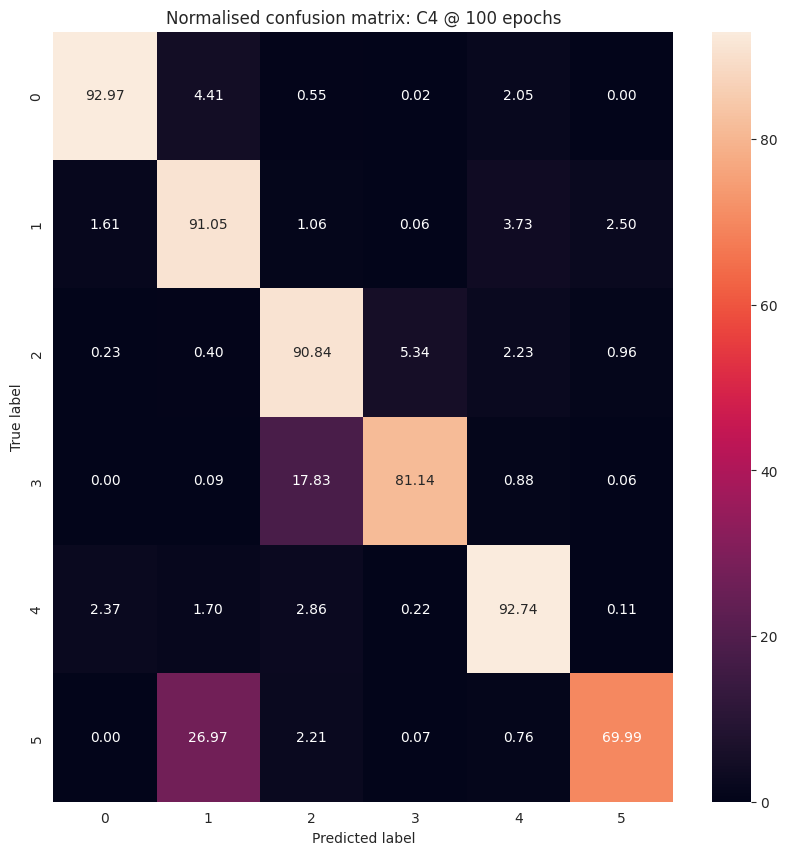

In [43]:
fig = plt.figure(figsize=(10, 10))
ax = sns.heatmap(data=data, annot=True, fmt=".2f")
ax.set_title(f"Normalised confusion matrix: C{GEN} @ {EPOCHS} epochs")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

In [42]:
samples = (
    "I can't believe you just that!",
    "What was that noise?",
    "I can't contain my excitement!",
    "This is amazing!",
    "Everything just fucking sucks.",
    "Oh my god, you did that for me?",
)
arr = net.predict(np.array(samples))
np.round(arr, 3)

1/1 [==============================] - 2s 2s/step


array([[0.354, 0.237, 0.182, 0.016, 0.21 , 0.001],
       [0.001, 0.797, 0.189, 0.003, 0.01 , 0.   ],
       [0.894, 0.006, 0.064, 0.   , 0.036, 0.   ],
       [0.   , 0.002, 0.509, 0.   , 0.004, 0.485],
       [0.036, 0.001, 0.   , 0.   , 0.963, 0.   ],
       [0.201, 0.209, 0.333, 0.007, 0.25 , 0.   ]], dtype=float32)